In [1]:
using Omega
using DataStructures
using Plots
using Statistics

┌ Info: Recompiling stale cache file /home/zenna/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


In this experiment we use the Lotka-Volterra model for counterfactual reasoning about population dynamics.
The Lotka-Volterra model is a pair of differential equations which represent interacting populations of predators (e.g. wolves) and prey (e.g. rabbits):

\begin{equation}
{\frac {dx}{dt}} =\alpha x-\beta xy \;\;\;\;\;\;
{\frac {dy}{dt}} =\delta xy-\gamma y
\end{equation}

where $x(t)$ and $y(t)$ represents the prey and predator, respectively.
Parameters $\alpha, \beta, \delta$ and $\gamma$ are positive constants which represent growth rates.

Suppose that after observing for $10$ days until `t_now = 20`, we discover that  the rabbit population is unsustainably high.
We want to ask counterfactual questions: how would an intervention now affect the future; had we intervened in this past, could we have avoided this situation?

In [2]:
function euler(f, u, t, tmax, Δt)
  if t < tmax
    let unext = u .+ f(t + Δt, u) .* Δt
      cons(u, euler(f, unext, t + Δt, tmax, Δt))
    end
  else
    nil()
  end
end

euler (generic function with 1 method)

### Deterministic model

Lotka Volterra represents dynamics of wolves and Rabbit Populations over time

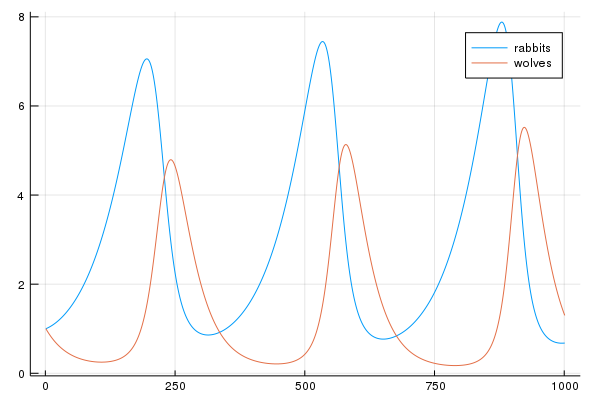

In [3]:
function lotka_volterra(t, u)
  x, y = u
  α, β, δ, γ = [1.5,1.0,3.0,1.0]
  dx = α*x - β*x*y
  dy = -δ*y + γ*x*y
  (dx, dy)
end

Δt = 0.01
geti(i, xs) = [x[i] for x in xs]
"Plot helper function"
plotts(x) = plot([geti(1, x), geti(2, x)], label = ["rabbits" "wolves"])
res = euler(lotka_volterra, (1.0, 1.0), 0.0, 10.0, Δt)
plotts(res)

### Probabilistic model

In [4]:
σ = 0.3
u0 = (normal(1.0, σ), normal(1.0, σ))ᵣ
α = normal(1.5, σ)
β = normal(1.0, σ)
γ = normal(3.0, σ)
δ = normal(1.0, σ)

getx(u) = u[1]
gety(u) = u[2]

gety (generic function with 1 method)

Next, we construct `lk_`: a random variable over derivative functions, where  $\alpha, \beta, \delta$ and $\gamma$ are the previously defined random variables.
In other words, a sample from `lk` is a function which maps a pair $u = (x, y)$ and current time t to the derivative with respect to time.

In [5]:
function lk_(ω)
  # Lotka Volterra represents dynamics of wolves and Rabbit Populations over time
  function lotka_volterra(t, u)
    x, y = u
    dx = α(ω)*x - β(ω)*x*y
    dy = -δ(ω)*y + γ(ω)*x*y
    (dx, dy)
  end
end

lk = ciid(lk_)

10:Main.##369.lk_()::getfield(Main.##369, Symbol("#lotka_volterra#3")){Omega.Space.ΩProj{Omega.Space.LinearΩ{Array{Int64,1},UnitRange{Int64},Array{Any,1}},Array{Int64,1}}}

Next, we complete the unconditional generative model.
Note that `euler` is converted into its lifted version, and `series` is a random variable.

In [6]:
tmax = constant(20)
euler_ = constant(euler)
series = ciid(ω -> euler_(ω)(lk(ω), u0(ω), 0, tmax(ω), Δt))

13:getfield(Main.##369, Symbol("##4#5"))()()::Any

series = lift(euler)(lk, u0, 0, 20, Δt)

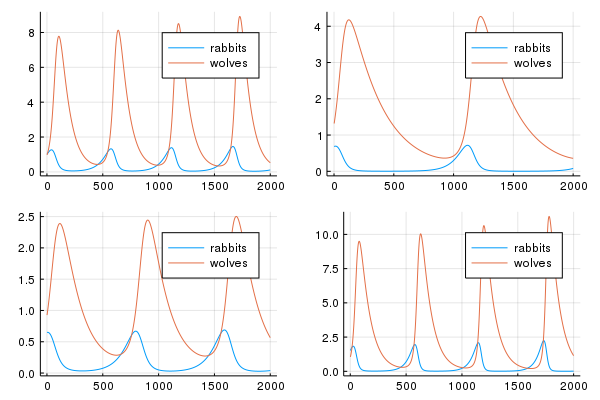

In [7]:
rabbitseries = lift(geti)(1, series)
plot([plotts(rand(series)) for i = 1:4]..., layout = (2, 2))

Next, we condition the prior on the observation that an average of 5 rabbits have been observed over the last 10 days.
We use a function \lastn(seq, n) to extract the last n elements of a seq, mean to compute the average, and \

In [8]:
"Filter series to lastn days"
lastn(series, ndays, Δt) =  series[end - Int(ceil(ndays / Δt)):end]

last10 = lift(lastn)(rabbitseries, 10, Δt)
toomanyrabbits = lift(Statistics.mean)(last10) ==ₛ 5.0
seriescond = cond(series, toomanyrabbits)

22:getfield(Omega, Symbol("##6#7")){Omega.URandVar{getfield(Main.##369, Symbol("##4#5")),Tuple{}},Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(Omega.Soft.softeq),Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(Statistics.mean),Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(Main.##369.lastn),Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(Main.##369.geti),Int64,Omega.URandVar{getfield(Main.##369, Symbol("##4#5")),Tuple{}}}},Int64,Float64}}}},Float64}}}(13:getfield(Main.##369, Symbol("##4#5"))()()::Any, 21:Omega.reifyapply(Omega.Soft.softeq, Omega.reifyapply, 5.0)::Any)()::Any

Let's draw a few samples

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]


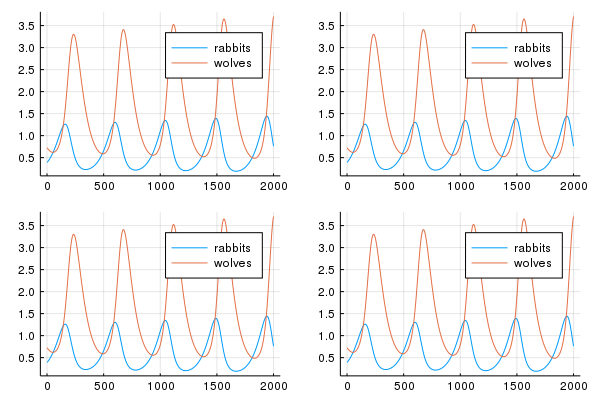

In [9]:
nsamples = 5
res = rand(series, toomanyrabbits, nsamples; alg = Replica)
plot([plotts(rand(res)) for i = 1:4]..., layout = (2, 2))

### Effect of action

Next, we examine the effect of action.  According to Pearl, action means intervening on the random variable being observed, which does not affect the past
In particular, if we were to increase the predator population by 5 at t_now, would the rabbit population be reduced?

In [10]:
function eulergen(t_int, u_int)
  function euler_int(f, u_, t, tmax, Δt)
    t, t_int, t ≈ t_int
    if t < tmax
      let u = t ≈ t_int ? u_int(u_) : u_,
          unext = u .+ f(t + Δt, u) .* Δt
        cons(u, euler_int(f, unext, t + Δt, tmax, Δt))
      end
    else
      nil()
    end
  end
end

eulergen (generic function with 1 method)

The next snippet intervenes on `series` using replace (i.e., do) to replace `euler` with an alternative version `eulerint` which increases the number of prediators.

In [11]:
tnow = 20
inc_pred = u -> (u[1]/2, u[2] + 5)
eulerint = eulergen(tnow, inc_pred)
series_int = replace(series, euler_ => constant(eulerint))
series_act = replace(seriescond, Dict(euler_ => constant(eulerint), tmax => constant(40)))

22:getfield(Omega, Symbol("##6#7")){Omega.URandVar{getfield(Main.##369, Symbol("##4#5")),Tuple{}},Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(Omega.Soft.softeq),Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(Statistics.mean),Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(Main.##369.lastn),Omega.URandVar{typeof(Omega.reifyapply),Tuple{typeof(Main.##369.geti),Int64,Omega.URandVar{getfield(Main.##369, Symbol("##4#5")),Tuple{}}}},Int64,Float64}}}},Float64}}}(13:getfield(Main.##369, Symbol("##4#5"))()()::Any, 21:Omega.reifyapply(Omega.Soft.softeq, Omega.reifyapply, 5.0)::Any)()::Any | intervened 

Plot four  counterfactual samples

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]


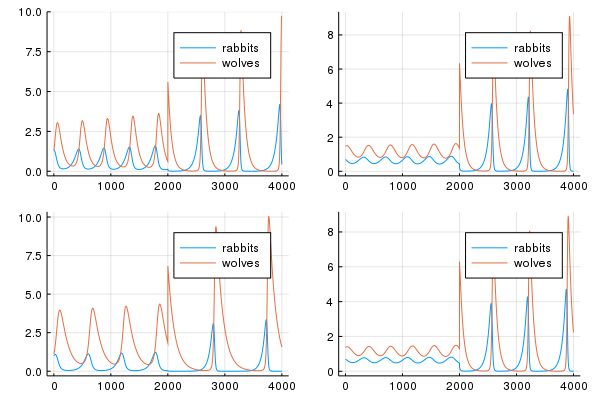

In [12]:
res = rand(series_act, nsamples; alg = Replica)
plot([plotts(rand(res)) for i = 1:4]..., layout = (2, 2))

Next, we consider the counterfactual: had we made an intervention at some previous time `t < t_now`, would the rabbit population have been less than it actually was over the last 10 days?

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]


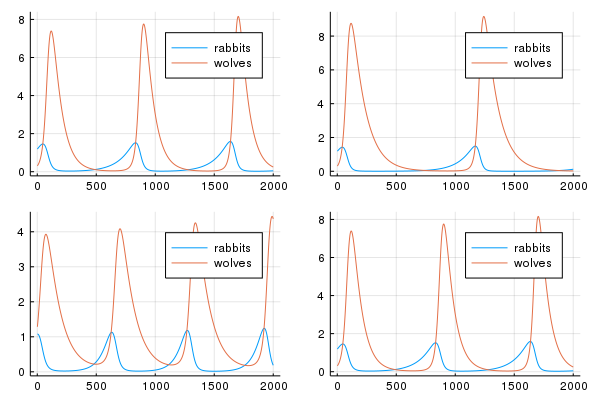

In [13]:
tnow = 20
cull_prey =  u-> (u[1]/2, y[2])
eulercf = eulergen(tnow, cull_prey)
series_cf = replace(seriescond, euler => eulercf)
res = rand(series_cf, nsamples; alg = Replica)
plot([plotts(rand(res)) for i = 1:4]..., layout = (2, 2))

Choosing a fixed time to intervene (e.g. $t = 5$)  is likely undesirable because it corresponds to an arbitrary (i.e.: parameter dependent) point in the predator-prey cycle.
Instead, the following snippet selects the intervention dynamically as a function of values in the non-intervened world.
`maxt` is an auxilliary function which selects the time at which the rabbit population is the largest hence is a random variable.

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]


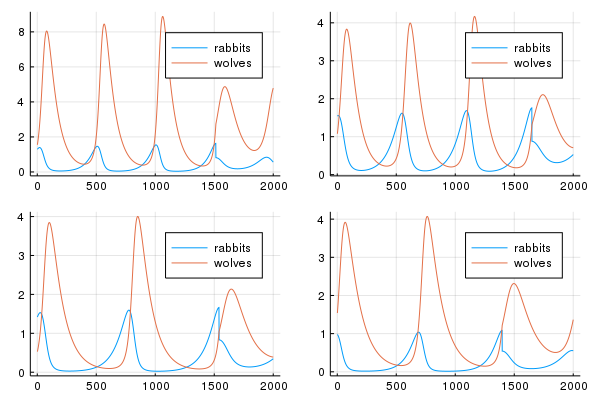

In [14]:
function maxt_(ω)
  m, i = findmax(rabbitseries(ω))
  (i - 1) * Δt
end

maxt = ciid(maxt_)
cull_prey =  u-> (u[1]/2, u[2])
eulercfdynamic = lift(eulergen)(maxt, cull_prey)
series_cf_dyn = ciid(ω -> replace(seriescond, euler_ => eulercfdynamic(ω))(ω))
res = rand(series_cf_dyn, nsamples; alg = Replica)
plot([plotts(rand(res)) for i = 1:4]..., layout = (2, 2))

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*